<a href="https://colab.research.google.com/github/zehrabarann/twitter-sentiment-analysis/blob/main/natural_language_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk
!pip install nltk
!pip install transformers
!pip install tqdm
nltk.download ('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
device = 'cuda' #set to cpu if you don't have gpu

!pip install gmaps
!pip install ipywidgets
!pip install widgetsnbextension
!pip install googlemaps
!pip install gmplot

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
import numpy as np
import pandas as pd
#import nltk
import torch
import xgboost as xgb


from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from spacy.lang.tr import Turkish

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding, CuDNNGRU
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from transformers import AutoModel, AutoTokenizer
from tqdm import trange
from tqdm import tqdm_notebook as tqdm

from gensim.models import Word2Vec 
from sklearn.manifold import TSNE ##kelime vektörlerini grafiğe dökmek için 
import matplotlib.pyplot as plt

import gmaps
import gmaps.datasets
import gmplot
from ipywidgets.embed import embed_minimal_html
import IPython


In [ ]:
dataset = pd.read_csv('/content/covidsonhal2_virgul_location.csv', delimiter = ',' , error_bad_lines=False, encoding = 'cp1254', header=None)
#dataset.head()
#cp1254


In [ ]:
dataset

,0,1,2,3,4,5
0,id,created_at,name,full_text,state,location
1,1259269894606139400,Sat May 09 23:51:53 +0000 2020,Çiğdem Sazak Öner,Terörden #covid’den umduğunu bulamayanlar #Tü...,0,Ankara
2,1259262866189889500,Sat May 09 23:23:57 +0000 2020,Nizâmulmülk,Depremler kasırgalar fırtınalar seller çekirg...,0,İstanbul
3,1259260850537365500,Sat May 09 23:15:57 +0000 2020,Ramazan benli,#Ankara Eğitim ve Araştırma Hastanesi’nde ver...,0,İzmir
4,1259260357979275300,Sat May 09 23:13:59 +0000 2020,Kısmet Yılmaz,Terörden #covid’den umduğunu bulamayanlar #Tü...,0,Adana
...,...,...,...,...,...,...
995,1263453004298170400,Thu May 21 12:54:04 +0000 2020,gs1905,Kader Göktepe Vize ödevlerinin ardından sonuçl...,1,Trabzon
996,1263529650690678800,Thu May 21 17:58:38 +0000 2020,Ebruliyim,Netflix te izlenecek bütün dizi ve filmleri b...,-1,Ordu
997,1263497010101002200,Thu May 21 15:48:56 +0000 2020,Athena,corona yüzünden en yakın arkadaşımı 3 aydır g...,-1,Giresun
998,1263454200392007700,Thu May 21 12:58:49 +0000 2020,engin,Pandemi sürecinde okuyamamak izleyememek anla...,0,İstanbul


In [ ]:
dataset.columns = ['id','created_at','name','full_text','state', 'location']

In [ ]:
dataset.dropna(inplace=True)  # Nan değerleri düşürür

In [ ]:
dataset.drop(0,inplace=True)

In [ ]:
data = dataset['full_text'].values.tolist() ##metin
target = dataset['state'].values.tolist() ##etiket

In [ ]:
dataset.iloc[:, 3:]

,full_text,state,location
1,Terörden #covid’den umduğunu bulamayanlar #Tü...,0,Ankara
2,Depremler kasırgalar fırtınalar seller çekirg...,0,İstanbul
3,#Ankara Eğitim ve Araştırma Hastanesi’nde ver...,0,İzmir
4,Terörden #covid’den umduğunu bulamayanlar #Tü...,0,Adana
5,Anneler tahliye Eşler tahliye Çocuklar tahliy...,0,İstanbul
...,...,...,...
995,Kader Göktepe Vize ödevlerinin ardından sonuçl...,1,Trabzon
996,Netflix te izlenecek bütün dizi ve filmleri b...,-1,Ordu
997,corona yüzünden en yakın arkadaşımı 3 aydır g...,-1,Giresun
998,Pandemi sürecinde okuyamamak izleyememek anla...,0,İstanbul


In [ ]:
data

[' Terörden #covid’den umduğunu bulamayanlar #Türkiye’yi dize getirme hayaliyle yine iş başında Hedefleri Türk ekonomisi ve küresel çetelerle mücâdelemizin bayraktarı olan @HMBakanligi Bakanımız Sn @BeratAlbayrak Ne yapsalar yine boş!Kaderlerinde mağlubiyet var #Başaramayacaksınız https://t.co/pg4LXVTcry',
 ' Depremler kasırgalar fırtınalar seller çekirge istilaları hayvandan insan virüs geçişleri #Covid #Corona salgını Mayıs ayında kar yağışı vs. vs. * Durum net: Dünyanın Genetik Yapısı Bozuldu??',
 ' #Ankara Eğitim ve Araştırma Hastanesi’nde verilmek üzere Ayşe Akkerman için çok #acil #Covid-19 hastalığını yenmiş kişilerden A Rh (+) #plazma kan ihtiyacı vardır. İletişim: 05534172227 https://t.co/GKcxL7Yfv9',
 ' Terörden #covid’den umduğunu bulamayanlar #Türkiye’yi dize getirme hayaliyle yine iş başında Hedefleri Türk ekonomisi ve küresel çetelerle mücâdelemizin bayraktarı olan @HMBakanligi Bakanımız Sn @BeratAlbayrak Ne yapsalar yine boş!Kaderlerinde mağlubiyet var #Başaramayacaksını

In [ ]:
import re
import string

In [ ]:
for i, item in enumerate(data):
  if type(item) is float: 
    data[i] = str(item)


In [ ]:
def cleanText(data):
  data = data.lower() ##küçük harfe çevirdi hepsini
  data = re.sub('\[.*?\]', '', data) ##köşeli parantez içindekileri atar
  data = re.sub('[%s]' % re.escape(string.punctuation), '', data) ##bütün noktalama işaretleri
  data = re.sub('\w*\d\w*', '', data) ##sayı içerenlerden kurtulma
  data = re.sub('[''""...]','',data)
  data = re.sub('\n', '', data)
  return data



In [ ]:
for index,item in enumerate(data):
  data[index] = cleanText(item)


In [ ]:
data

[' terörden covid’den umduğunu bulamayanlar türkiye’yi dize getirme hayaliyle yine iş başında hedefleri türk ekonomisi ve küresel çetelerle mücâdelemizin bayraktarı olan hmbakanligi bakanımız sn beratalbayrak ne yapsalar yine boşkaderlerinde mağlubiyet var başaramayacaksınız ',
 ' depremler kasırgalar fırtınalar seller çekirge istilaları hayvandan insan virüs geçişleri covid corona salgını mayıs ayında kar yağışı vs vs  durum net dünyanın genetik yapısı bozuldu',
 ' ankara eğitim ve araştırma hastanesi’nde verilmek üzere ayşe akkerman için çok acil  hastalığını yenmiş kişilerden a rh  plazma kan ihtiyacı vardır i̇letişim  ',
 ' terörden covid’den umduğunu bulamayanlar türkiye’yi dize getirme hayaliyle yine iş başında hedefleri türk ekonomisi ve küresel çetelerle mücâdelemizin bayraktarı olan hmbakanligi bakanımız sn beratalbayrak ne yapsalar yine boşkaderlerinde mağlubiyet var başaramayacaksınız ',
 ' anneler tahliye eşler tahliye çocuklar tahliye hastalar tahliye cezaevleri  tehdidi a

In [ ]:
def filter(text):
    final_text = ' '
    for word in text.split():
     if word.startswith('@'):
       continue
     elif word[-3:] in ['com', 'org']:
       continue
     elif word.startswith ('pic') or word.startswith('http') or word.startswith('www'):
       continue
     else:
       final_text += word+' '
    
    return final_text


In [ ]:
for index,item in enumerate(data):
  data[index] = filter(item)

In [ ]:
data

[' terörden covid’den umduğunu bulamayanlar türkiye’yi dize getirme hayaliyle yine iş başında hedefleri türk ekonomisi ve küresel çetelerle mücâdelemizin bayraktarı olan hmbakanligi bakanımız sn beratalbayrak ne yapsalar yine boşkaderlerinde mağlubiyet var başaramayacaksınız ',
 ' depremler kasırgalar fırtınalar seller çekirge istilaları hayvandan insan virüs geçişleri covid corona salgını mayıs ayında kar yağışı vs vs durum net dünyanın genetik yapısı bozuldu ',
 ' ankara eğitim ve araştırma hastanesi’nde verilmek üzere ayşe akkerman için çok acil hastalığını yenmiş kişilerden a rh plazma kan ihtiyacı vardır i̇letişim ',
 ' terörden covid’den umduğunu bulamayanlar türkiye’yi dize getirme hayaliyle yine iş başında hedefleri türk ekonomisi ve küresel çetelerle mücâdelemizin bayraktarı olan hmbakanligi bakanımız sn beratalbayrak ne yapsalar yine boşkaderlerinde mağlubiyet var başaramayacaksınız ',
 ' anneler tahliye eşler tahliye çocuklar tahliye hastalar tahliye cezaevleri tehdidi altın

In [ ]:
full_text_list = [full_text for full_text in data]

big_list =' '.join(full_text_list)

tokens = word_tokenize(big_list)

stop_words = set(stopwords.words('turkish'))

words = [word.lower() for word in tokens if word.isalpha()]

words = [word for word in words if not word in stop_words]

data2 = words
data2

['terörden',
 'covid',
 'den',
 'umduğunu',
 'bulamayanlar',
 'türkiye',
 'yi',
 'dize',
 'getirme',
 'hayaliyle',
 'yine',
 'iş',
 'başında',
 'hedefleri',
 'türk',
 'ekonomisi',
 'küresel',
 'çetelerle',
 'mücâdelemizin',
 'bayraktarı',
 'olan',
 'hmbakanligi',
 'bakanımız',
 'sn',
 'beratalbayrak',
 'yapsalar',
 'yine',
 'boşkaderlerinde',
 'mağlubiyet',
 'var',
 'başaramayacaksınız',
 'depremler',
 'kasırgalar',
 'fırtınalar',
 'seller',
 'çekirge',
 'istilaları',
 'hayvandan',
 'insan',
 'virüs',
 'geçişleri',
 'covid',
 'corona',
 'salgını',
 'mayıs',
 'ayında',
 'kar',
 'yağışı',
 'vs',
 'vs',
 'durum',
 'net',
 'dünyanın',
 'genetik',
 'yapısı',
 'bozuldu',
 'ankara',
 'eğitim',
 'araştırma',
 'hastanesi',
 'nde',
 'verilmek',
 'üzere',
 'ayşe',
 'akkerman',
 'acil',
 'hastalığını',
 'yenmiş',
 'kişilerden',
 'a',
 'rh',
 'plazma',
 'kan',
 'ihtiyacı',
 'vardır',
 'terörden',
 'covid',
 'den',
 'umduğunu',
 'bulamayanlar',
 'türkiye',
 'yi',
 'dize',
 'getirme',
 'hayaliyle',
 

In [ ]:
#window ile ortadak kelimenin sağından ve solundan o kadar ilerlenir.
#mincount=5 ile en az 5 defa geçen kelimeler alınır.
#sg=1 ile skip gram algoritmasının kullanılacağı belirtilir. 
#iter=10 korpus üzerindeki yineleme sayısı 
model = Word2Vec([data2], size=64, window=8, min_count=2, workers=8, iter=10, sg=1 )


In [ ]:
model.wv['corona']

array([ 3.2562712e-01,  1.7684639e-01,  7.3686704e-02, -1.0229807e-01,
       -3.1709427e-01,  1.9100897e-01,  2.3351340e-01, -1.9799136e-01,
       -1.2435904e-01, -1.5564200e-01, -1.1944799e-01, -8.7149842e-03,
       -5.2545130e-02, -3.5043864e-04,  1.8885347e-01,  1.4649060e-01,
        1.6382688e-01,  1.0852989e-01, -1.1429775e-01,  3.1424257e-01,
        4.2107146e-02,  3.3424187e-02, -6.6788070e-02, -9.0328254e-02,
        3.7965545e-01,  3.7517923e-01,  1.6546013e-02, -2.1882677e-02,
        1.1527239e-01,  2.4599233e-01,  2.8316647e-02, -2.4146989e-01,
        2.5245517e-01,  1.8296124e-01,  1.4866370e-01,  3.4554577e-01,
        2.9954654e-01,  6.2173367e-02, -9.3219839e-02, -5.4833665e-03,
        8.7876238e-02, -1.8504369e-01,  1.1427916e-01, -2.8425828e-01,
        6.4474423e-03,  3.1392135e-02, -3.7600949e-02, -4.9611043e-02,
       -7.3657304e-02, -1.1896546e-01,  1.0081181e-01, -3.2905051e-01,
        5.2839361e-02, -8.6598754e-02,  2.3932214e-01,  1.0353347e-01,
      

In [ ]:
model.wv.most_similar('corona') ##benzer olanları getirmesi lazım 

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('yok', 0.9874268770217896),
 ('bir', 0.9873181581497192),
 ('artık', 0.9853891134262085),
 ('bile', 0.9847429990768433),
 ('olsun', 0.983119547367096),
 ('bi', 0.981909990310669),
 ('gün', 0.9809420704841614),
 ('oldu', 0.9797702431678772),
 ('zaten', 0.9778648018836975),
 ('zaman', 0.9776192903518677)]

In [ ]:
model.save('word2vec.model') ##modeli kaydeder

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
model = Word2Vec.load('word2vec.model') ##modeli yükleme

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
cutoff = int(len(data) * 0.8)
X_train, Y_train = data[:cutoff], data[cutoff:]
X_test, Y_test = target[:cutoff], target[cutoff:]

In [ ]:
#data2[i]

In [ ]:
def feature_extraction(data):
  vektor = np.zeros(64)
  splitdata = data.split()
  for splitem in splitdata:   
    if splitem in model:
      vektor = vektor + model[splitem]     
    #print(vektor)
    #vektor = vektor.split('\n') 
  return vektor

Verileri cümle cünle göndercezz.
Cümle modelde varmı if. 
Varsa modelde karşılığı yani vektör dönüyor.
Vektör cümle bitenede toplanıyor.
Cümlenin toplam vektörü sana dönüyor.

In [ ]:
X_train

[' terörden covid’den umduğunu bulamayanlar türkiye’yi dize getirme hayaliyle yine iş başında hedefleri türk ekonomisi ve küresel çetelerle mücâdelemizin bayraktarı olan hmbakanligi bakanımız sn beratalbayrak ne yapsalar yine boşkaderlerinde mağlubiyet var başaramayacaksınız ',
 ' depremler kasırgalar fırtınalar seller çekirge istilaları hayvandan insan virüs geçişleri covid corona salgını mayıs ayında kar yağışı vs vs durum net dünyanın genetik yapısı bozuldu ',
 ' ankara eğitim ve araştırma hastanesi’nde verilmek üzere ayşe akkerman için çok acil hastalığını yenmiş kişilerden a rh plazma kan ihtiyacı vardır i̇letişim ',
 ' terörden covid’den umduğunu bulamayanlar türkiye’yi dize getirme hayaliyle yine iş başında hedefleri türk ekonomisi ve küresel çetelerle mücâdelemizin bayraktarı olan hmbakanligi bakanımız sn beratalbayrak ne yapsalar yine boşkaderlerinde mağlubiyet var başaramayacaksınız ',
 ' anneler tahliye eşler tahliye çocuklar tahliye hastalar tahliye cezaevleri tehdidi altın

In [ ]:
difference = {'negative':-1 , 'neutral':0, 'positive':1}
x_train = [] #data
y_train = [] #etiket
x_test = []
y_test = []
for i,element in enumerate(tqdm(X_train)):
  x_train.append(feature_extraction(element))
for element in tqdm(X_test):
  x_test.append(int(element))
for i,element in enumerate(tqdm(Y_train)):
  y_train.append(feature_extraction(element))
for element in tqdm(Y_test):
  y_test.append(int(element))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


In [ ]:
#print(X_train[45])
print(x_train[45])
print(x_test[45])


[ 4.83458614  2.98706996  0.07945952 -0.99997733 -3.26961659  1.08785655
  2.61597989 -1.99982749 -2.30012707 -1.43401654 -1.11038596 -0.27408021
 -0.76441012  0.25370819  1.42195868  2.54899903  2.06136078  1.37309983
 -0.1343857   2.7864884   0.46000807  1.31712523  0.65871944 -1.52893418
  2.91827662  4.35001013 -0.06167236 -0.07204954  2.65683877  2.83351707
 -0.41675904 -2.47015753  2.47664107  1.47227978  1.85111829  4.10164648
  4.13518035  1.06324716 -0.81897093 -0.38609539  0.25319467 -0.40938958
  1.09168587 -2.63351001  0.56627747 -0.07448923 -0.88156907 -0.02911124
 -0.35219634 -1.2458937   1.45030221 -4.11887944  1.03762519  0.18139968
  2.11841078  1.29319515 -1.70034868 -3.90718699  1.02375785  5.90564042
 -0.42451956  1.32090553 -1.12772771  1.31240351]
-1


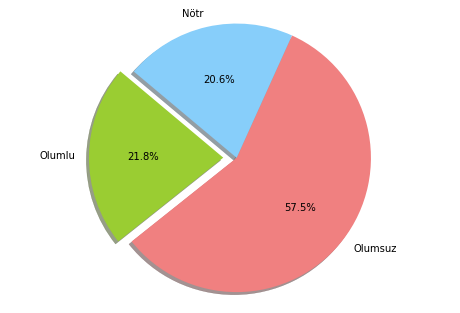

In [ ]:
import matplotlib.pyplot as plt
x,y,z = 0,0,0
# Data to plot
labels =["Olumlu","Olumsuz","Nötr"]
for i in range(0,len(x_test)):
  if x_test[i] == 0:
    x += 1
  if x_test[i] == 1:
    y += 1
  if x_test[i] == -1:
    z += 1
    
sizes = [y, z, x]
colors = ['yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

PCA yüksek boyutlu bir alandan düşük boyutlu bir alt uzaya yansıtmak için kullanılan doğrusal bir boyutsallık azaltma tekniğidir. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')
import matplotlib.patches as mpatches

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
#Modified from https://web.stanford.edu/class/cs224n/materials/Gensim%20word%20vector%20visualization.html
def display_pca_scatterplot(X, y, sample=100):
    indices = np.random.choice(list(range(len(X))), sample)
    X_sample = np.array(X)[indices]
    y_sample = np.array(y)[indices]

    twodim = PCA().fit_transform(X_sample)[:,:2]
   # print(twodim)
    plt.figure(figsize=(6,6))
    for idx, el in enumerate(X_sample):
        try:
          if (int(y_sample[idx]) == 1):
              color = 'green'
          elif (int(y_sample[idx]) == 0):
              color = 'blue'
          else:
              color = 'red'
          plt.scatter(el[0], el[1], edgecolors='k', c=color)
          #print(str(el[0]) +" " +  str(y_sample[idx]))
          #print(str(el[1]) + " " +  str(y_sample[idx]))
        except:
          print("Nan")
    red_patch = mpatches.Patch(color='red', label='Negatif')
    green_patch = mpatches.Patch(color='green', label='Pozitif')
    black_patch = mpatches.Patch(color='blue', label='Nötr')
    plt.legend(handles=[red_patch, black_patch, green_patch])


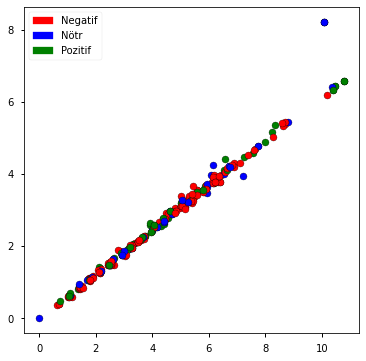

In [ ]:
d0isplay_pca_scatterplot(x_train, x_test, 300)

Train model using Machine Learning

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model = RandomForestClassifier(n_estimators=700).fit(x_train,x_test)

In [ ]:
preds = model.predict(y_train)

In [ ]:
print(confusion_matrix(y_test,preds))
print(classification_report(y_test,preds))

[[99  1  4]
 [37  1  2]
 [43  1  5]]
              precision    recall  f1-score   support

          -1       0.55      0.95      0.70       104
           0       0.33      0.03      0.05        40
           1       0.45      0.10      0.17        49

    accuracy                           0.54       193
   macro avg       0.45      0.36      0.30       193
weighted avg       0.48      0.54      0.43       193



In [ ]:
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(np.array(x_train), np.array(x_test))
predictions = gbm.predict(y_train)

In [ ]:
print(confusion_matrix(y_test,predictions))
#print(confusion_matrix(x_train,x_test))
print(classification_report(y_test,predictions))

[[84  6 14]
 [35  2  3]
 [42  3  4]]
              precision    recall  f1-score   support

          -1       0.52      0.81      0.63       104
           0       0.18      0.05      0.08        40
           1       0.19      0.08      0.11        49

    accuracy                           0.47       193
   macro avg       0.30      0.31      0.28       193
weighted avg       0.37      0.47      0.39       193



In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(np.array(x_train), np.array(x_test))

predictions = gnb.predict(y_train)
predictions

array([ 0,  1, -1, -1, -1, -1,  1, -1, -1, -1,  0, -1, -1, -1, -1,  1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1, -1, -1, -1,  1, -1, -1,
        1, -1,  0, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  0,
       -1, -1, -1, -1, -1, -1,  1,  1, -1, -1, -1,  1, -1, -1,  0, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1,  1, -1,  1, -1,  1, -1, -1, -1, -1,  1,
       -1, -1,  0, -1,  1, -1, -1, -1, -1, -1, -1,  1, -1, -1,  0,  1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1,  0, -1, -1,
       -1, -1, -1, -1,  0, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1,
        1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,
        1, -1, -1, -1, -1, -1])

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(np.array(y_test),predictions))
#print(confusion_matrix(np.array(x_train),np.array(x_test)))
print(classification_report(y_test,predictions))


[[87  5 12]
 [30  1  9]
 [39  4  6]]
              precision    recall  f1-score   support

          -1       0.56      0.84      0.67       104
           0       0.10      0.03      0.04        40
           1       0.22      0.12      0.16        49

    accuracy                           0.49       193
   macro avg       0.29      0.33      0.29       193
weighted avg       0.38      0.49      0.41       193



In [ ]:
#Dependencies
#input_dim = np.array(x_train).shape[1]
#import keras
#from keras.models import Sequential

# Neural network
#model = Sequential()
#model.add(Flatten())
#model.add(Dense(10, input_dim=input_dim, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
#model.add(Dense(1024, input_shape=(64,), activation= 'sigmoid')) ##16   ##input_dim=20
#model.add(Dense(512, activation = 'sigmoid'))  ##12
#model.add(Dense(1, activation = 'softmax'))  ##output dimension = 4 (classes)

In [ ]:
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) ##loss=categorical_crossentropy

In [ ]:
#model.summary()


In [ ]:
#np.array(x_train)

In [ ]:
#history = model.fit(np.array(x_train), np.array(x_test), validation_data=(np.array(y_train), np.array(y_test)), epochs=100, batch_size=10, verbose=1)

MAPS

In [ ]:
!pip install gmaps
!pip install ipywidgets
!pip install widgetsnbextension
!pip install googlemaps
!pip install gmplot

In [ ]:
konum = {"İstanbul": [41.011046, 28.957798], "Ankara": [39.911652, 32.840305], "İzmir": [38.412726, 27.138376], "Bursa": [40.195593,	29.06013],
         "Adana": [37.001667,	35.328889], "Antep": [37.059444,	37.3825], "Konya": [37.871354, 32.484636], "Mersin": [36.91766, 34.892773],
         "Antalya": [36.908118,	30.695565], "Trabzon": [41.005,	39.726944], "Diyarbakır": [37.913629, 40.217213], "Kayseri": [38.732222,	35.485278],
         "Eskişehir": [39.776667,	30.520556], "Kocaeli": [40.766944,	29.916944], "Malatya": [38.350183, 38.316669], "Erzurum": [39.908611,	41.276944],
         "Kahramanmaraş": [37.584705,	36.926405], "Denizli": [37.774167,	29.0875], "Van": [38.494565, 43.383231], "Hatay": [36.206551,	36.157225],
         "Rize": [41.020833,	40.521944], "Elazığ": [38.674314,	39.223206], "Sivas": [39.748333, 37.016111], "Balıkesir": [39.649167,	27.886111],
         "Kırıkkale": [39.845278,	33.506389], "Kütahya": [39.424167,	29.983333], "Zonguldak": [41.451392,	31.793053], "Sakarya": [40.780556,	30.403333],
         "Ordu": [40.97793,	37.870851], "Erzincan": [39.739186,	39.490152], "Karabük": [41.204884,	32.62768], "Edirne": [41.675745,	26.558665], 
         "Tekirdağ": [40.978012,	27.508524], "Giresun": [40.91698,	38.387406], "Tokat": [40.313889,	36.554444], "Bolu": [40.735833,	31.606111],
         "Kırşehir": [39.145833,	34.163889], "Niğde": [37.965834,	34.679352], "Ağrı": [39.714666,	43.040151], "Çanakkale": [40.155523,	26.412707],
         "Hakkari": [37.574444,	43.740833], "Kars": [40.59825,	43.085477], "Muğla": [37.218066,	28.366497], "Tunceli": [39.099212,	39.543511] }



In [ ]:
dts_loc = dataset["location"]

In [ ]:
dataset['location'] = dataset['location'].str.strip() ##boşluk gider

In [ ]:
df = dataset.groupby('location')['id'].nunique() ##locatina göre grup


In [ ]:
lang = ""
lung = ""
data_loc = []
for i, item in df.items():
  for loc in konum:
    if i in loc:
      lang = konum[loc][0]
      lung = konum[loc][1]
      data_loc.append([lang,lung,item])
    else:
      lang = ""
      lung = ""

df_location = pd.DataFrame(data_loc, columns= ["latitude","longitude","magnitude"])

In [ ]:
df_location

,latitude,longitude,magnitude
0,37.001667,35.328889,45
1,39.911652,32.840305,100
2,36.908118,30.695565,32
3,37.059444,37.382500,1
4,39.714666,43.040151,8
5,39.649167,27.886111,8
6,40.735833,31.606111,14
7,40.195593,29.060130,45
8,37.774167,29.087500,5
9,37.913629,40.217213,5


In [ ]:
gmaps.configure(api_key='Your api key')


In [ ]:
locations = df_location[['latitude', 'longitude']]
weights = df_location['magnitude']
fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(locations, weights=weights))
fig


Figure(layout=FigureLayout(height='420px'))

In [ ]:
embed_minimal_html('export.html', views=[fig])

In [ ]:
IPython.display.HTML(filename='export.html')
